In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import matplotlib.pyplot as plt

In [7]:
data_dir = 'C:/Users/Asus/Desktop/Plant/Plant/dataset'

In [8]:
datagen = ImageDataGenerator(
    rescale=1.0/255.0,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest',  
    validation_split=0.3  
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),  
    batch_size=16,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=16,
    class_mode='categorical',
    subset='validation'
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator, 
    output_signature=( 
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generator.class_indices)), dtype=tf.float32)
    )
).repeat() 

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator, 
    output_signature=( 
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, len(train_generator.class_indices)), dtype=tf.float32)
    )
).repeat()  

Found 8758 images belonging to 2 classes.
Found 3753 images belonging to 2 classes.


In [9]:
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", val_generator.samples)

print(train_generator.class_indices)

Number of training samples: 8758
Number of validation samples: 3753
{'disease': 0, 'healthy': 1}


In [10]:
base_model = ResNet50V2(
    weights='imagenet',  
    include_top=False, 
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),  
    Dense(128, activation='relu'),  
    Dense(len(train_generator.class_indices), activation='softmax')  
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

In [12]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_dataset,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5,
    callbacks=[early_stopping]  
)

Epoch 1/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1322s 2s/step - accuracy: 0.8682 - loss: 0.3143 - val_accuracy: 0.8902 - val_loss: 0.3169
Epoch 2/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1056s 2s/step - accuracy: 0.9464 - loss: 0.1363 - val_accuracy: 0.9390 - val_loss: 0.1634
Epoch 3/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1179s 2s/step - accuracy: 0.9666 - loss: 0.0908 - val_accuracy: 0.9454 - val_loss: 0.1317
Epoch 4/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1107s 2s/step - accuracy: 0.9681 - loss: 0.0858 - val_accuracy: 0.9430 - val_loss: 0.1470
Epoch 5/5
547/547 ━━━━━━━━━━━━━━━━━━━━ 1092s 2s/step - accuracy: 0.9656 - loss: 0.0815 - val_accuracy: 0.9478 - val_loss: 0.1313


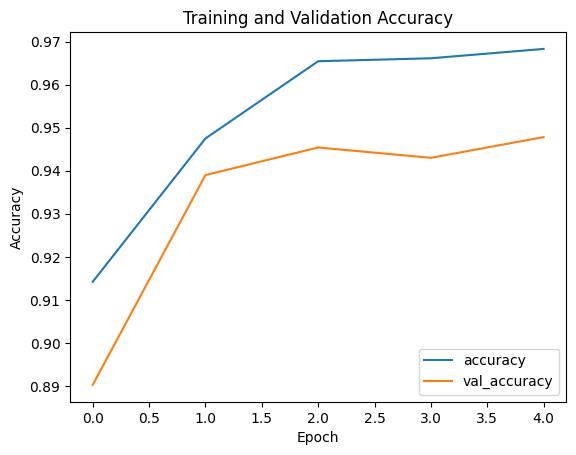

In [13]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
Class: healthy
Confidence Score: 63.84803056716919 %


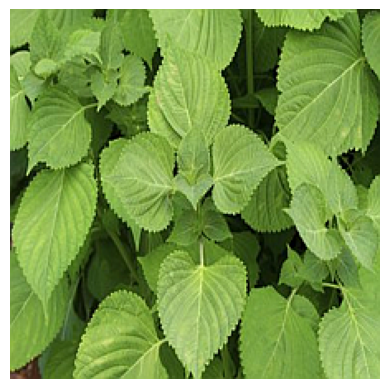

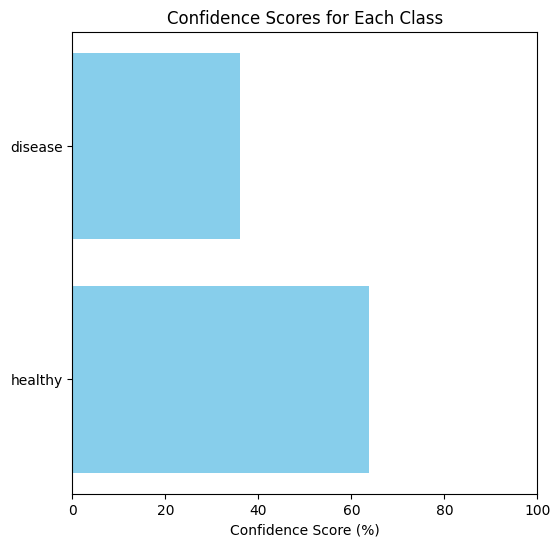

In [31]:
from PIL import Image, ImageFilter
import numpy as np

#Test Img Path
img_path = 'C:/Users/Asus/Downloads/leaf_healthy2.jpg'

img = Image.open(img_path).resize((224, 224))

sharpened_img = img.filter(ImageFilter.SHARPEN)

x = np.array(sharpened_img) / 255.0
x = np.expand_dims(x, axis=0)  

preds = model.predict(x)

pred_class = np.argmax(preds)
class_labels = {v: k for k, v in train_generator.class_indices.items()}  # Mapping index เป็นชื่อคลาส
print('Class:', class_labels[pred_class])
print('Confidence Score:', np.max(preds) * 100, '%')

plt.imshow(sharpened_img)
plt.axis('off')
plt.show()

plt.figure(figsize=(6, 6))
plt.barh(list(class_labels.values()), preds[0] * 100, color='skyblue')
plt.xlabel('Confidence Score (%)')
plt.title('Confidence Scores for Each Class')
plt.xlim(0, 100)
plt.gca().invert_yaxis()
plt.show()

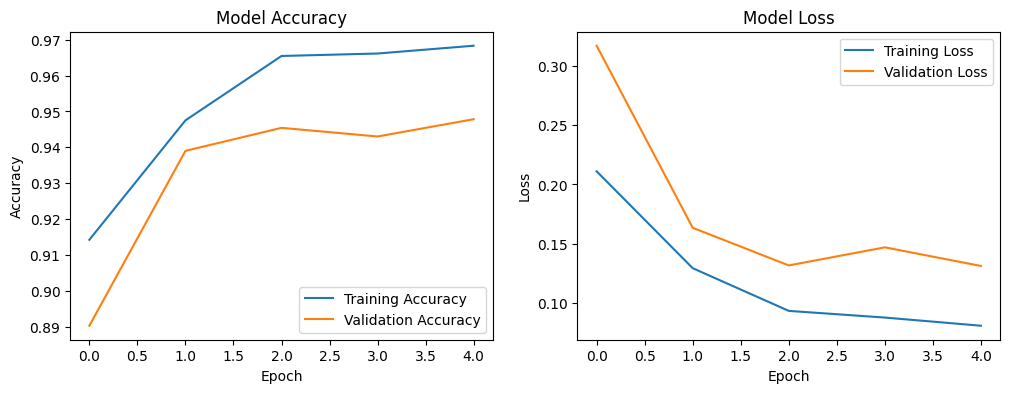

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(val_generator)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

In [24]:
from sklearn.metrics import classification_report

y_true = val_generator.classes  
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

report = classification_report(y_true, y_pred_classes, target_names=list(class_labels.values()))
print(report)

235/235 ━━━━━━━━━━━━━━━━━━━━ 312s 1s/step
              precision    recall  f1-score   support

     disease       0.73      0.74      0.74      2772
     healthy       0.24      0.23      0.23       981

    accuracy                           0.61      3753
   macro avg       0.49      0.49      0.49      3753
weighted avg       0.60      0.61      0.60      3753



# Save Model

In [38]:
#Save .h5
model.save('kodman.h5')

#Convert to TFlite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

#Save Tflite
with open('kodman.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpnli4npqr\assets


INFO:tensorflow:Assets written to: C:\Users\Asus\AppData\Local\Temp\tmpnli4npqr\assets


Saved artifact at 'C:\Users\Asus\AppData\Local\Temp\tmpnli4npqr'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_190')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  1853556527344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853555953904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853560709888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853560710240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853560709360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853560709536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853559683024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853559699056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853559700112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1853559697472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  18